In [1]:
# INSTALL LIBRARIES
!pip install pandas boto3 scikit-learn matplotlib seaborn wordcloud xgboost


In [15]:
# IMPORTS
import pandas as pd
import boto3
import joblib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb



In [3]:
!pip install lightgbm

In [16]:
# LOAD BOTH ORIGINAL & PREPROCESSED DATASETS
bucket = 'youtube-trending-cleaned'
original_key = 'US_youtube_trending_data.csv'
preprocessed_key = 'Pre_Processed_US_YouTube_Trending_Videos.csv' 

s3 = boto3.client('s3')
original_df = pd.read_csv(s3.get_object(Bucket=bucket, Key=original_key)['Body'])
preprocessed_df = pd.read_csv(s3.get_object(Bucket=bucket, Key=preprocessed_key)['Body'])


In [17]:
# SUMMARY COMPARISONS
print("\n===== Dataset Size Comparison =====")
print(f"Original Dataset Rows: {len(original_df)}")
print(f"Preprocessed Dataset Rows: {len(preprocessed_df)}")

missing_original = original_df.isnull().sum().sum()
missing_preprocessed = preprocessed_df.isnull().sum().sum()
print("\n===== Missing Values Comparison =====")
print(f"Total Missing Values in Original: {missing_original}")
print(f"Total Missing Values in Preprocessed: {missing_preprocessed}")

unique_original = original_df['video_id'].nunique()
unique_preprocessed = preprocessed_df['video_id'].nunique()
print("\n===== Unique Videos Comparison =====")
print(f"Unique videos in Original: {unique_original}")
print(f"Unique videos in Preprocessed: {unique_preprocessed}")



===== Dataset Size Comparison =====
Original Dataset Rows: 268787
Preprocessed Dataset Rows: 45043

===== Missing Values Comparison =====
Total Missing Values in Original: 4549
Total Missing Values in Preprocessed: 936

===== Unique Videos Comparison =====
Unique videos in Original: 47142
Unique videos in Preprocessed: 7901


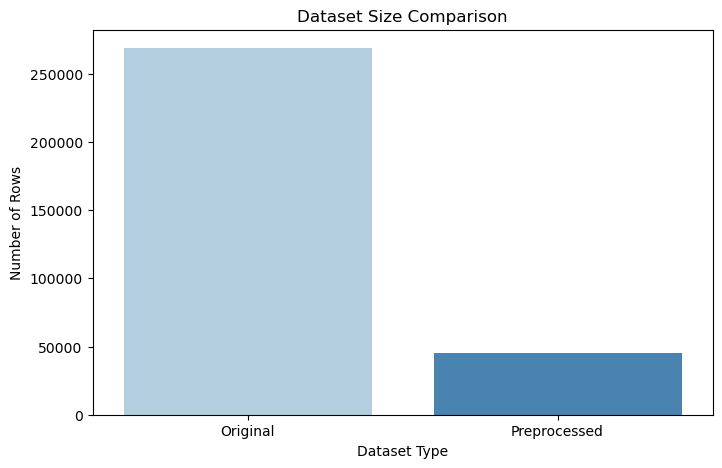

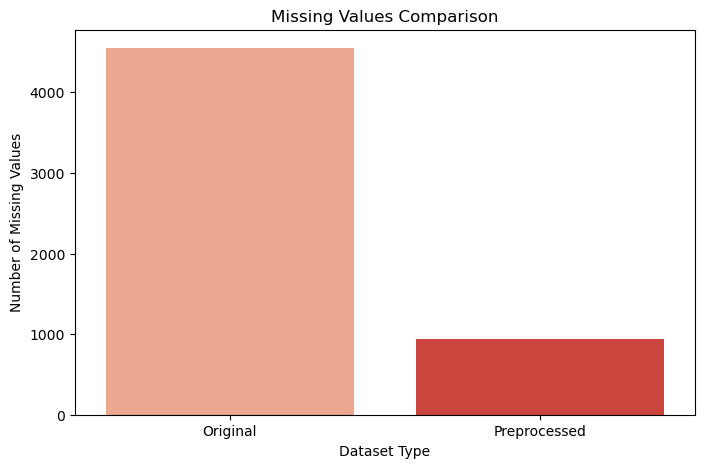

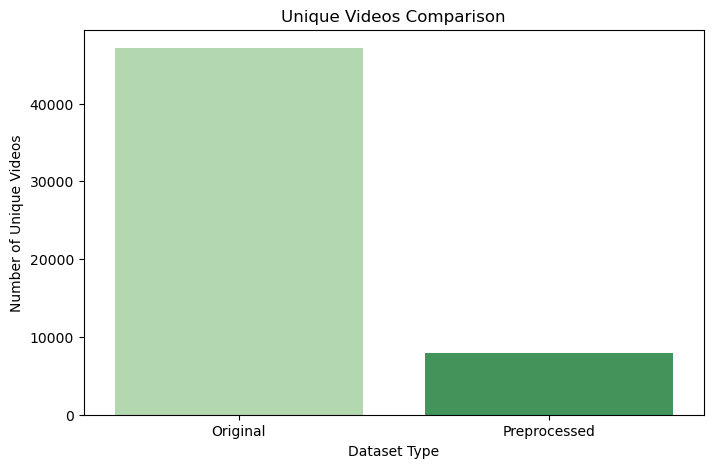

In [18]:
# TRENDY VISUAL COMPARISONS
plt.figure(figsize=(8,5))
sns.barplot(x=['Original', 'Preprocessed'], y=[len(original_df), len(preprocessed_df)],
            hue=['Original', 'Preprocessed'], palette='Blues', legend=False)
plt.title('Dataset Size Comparison')
plt.xlabel('Dataset Type')
plt.ylabel('Number of Rows')
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(x=['Original', 'Preprocessed'], y=[missing_original, missing_preprocessed],
            hue=['Original', 'Preprocessed'], palette='Reds', legend=False)
plt.title('Missing Values Comparison')
plt.xlabel('Dataset Type')
plt.ylabel('Number of Missing Values')
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(x=['Original', 'Preprocessed'], y=[unique_original, unique_preprocessed],
            hue=['Original', 'Preprocessed'], palette='Greens', legend=False)
plt.title('Unique Videos Comparison')
plt.xlabel('Dataset Type')
plt.ylabel('Number of Unique Videos')
plt.show()


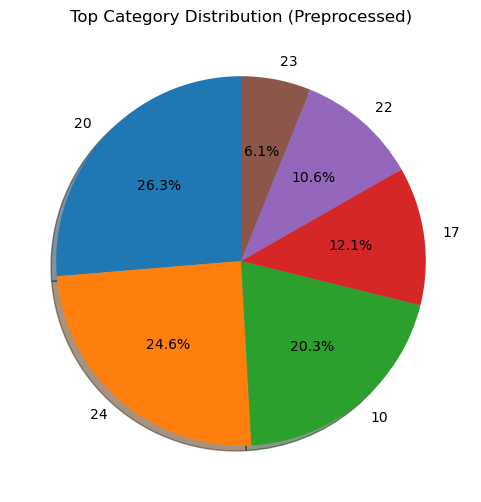

In [19]:
# PIE CHART FOR CATEGORY DISTRIBUTION (Preprocessed)
plt.figure(figsize=(6,6))
preprocessed_df['categoryId'].value_counts().head(6).plot.pie(autopct='%1.1f%%', startangle=90, shadow=True)
plt.title('Top Category Distribution (Preprocessed)')
plt.ylabel('')
plt.show()

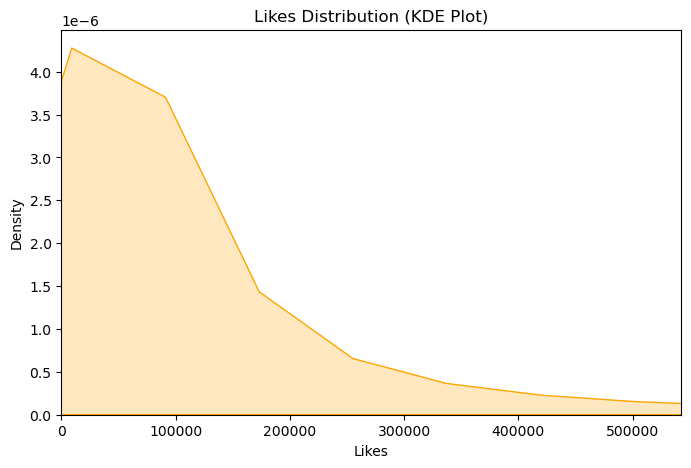

In [20]:
# KDE PLOT FOR LIKES DISTRIBUTION
plt.figure(figsize=(8,5))
sns.kdeplot(data=preprocessed_df, x='likes', fill=True, color='orange')
plt.title('Likes Distribution (KDE Plot)')
plt.xlabel('Likes')
plt.ylabel('Density')
plt.xlim(0, preprocessed_df['likes'].quantile(0.95))  
plt.show()

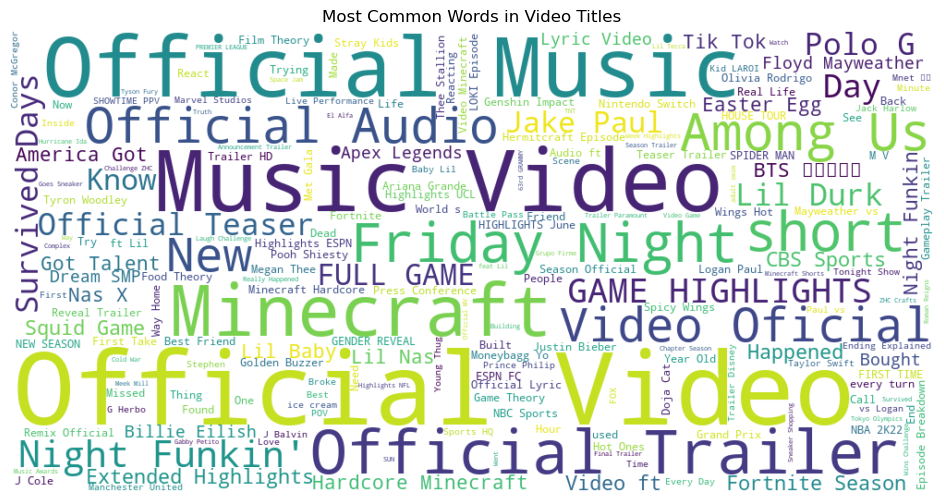

In [21]:
# WORD CLOUD FROM VIDEO TITLES
title_text = ' '.join(preprocessed_df['title'].dropna().tolist())
wordcloud = WordCloud(width=1000, height=500, background_color='white', colormap='viridis').generate(title_text)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Video Titles')
plt.show()

In [22]:
# MODELING PIPELINE
data = preprocessed_df.copy()
data = data.drop(['video_id', 'publishedAt', 'thumbnail_link', 'channelId'], axis=1)
data['description'] = data['description'].fillna('')
data['is_trending'] = (data['view_count'] > data['view_count'].median()).astype(int)
data = pd.get_dummies(data, columns=['channelTitle'], drop_first=True)
data = data.drop(['tags', 'title', 'description', 'trending_date'], axis=1)

X = data.drop('is_trending', axis=1)
y = data['is_trending']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



===== LightGBM Model =====
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

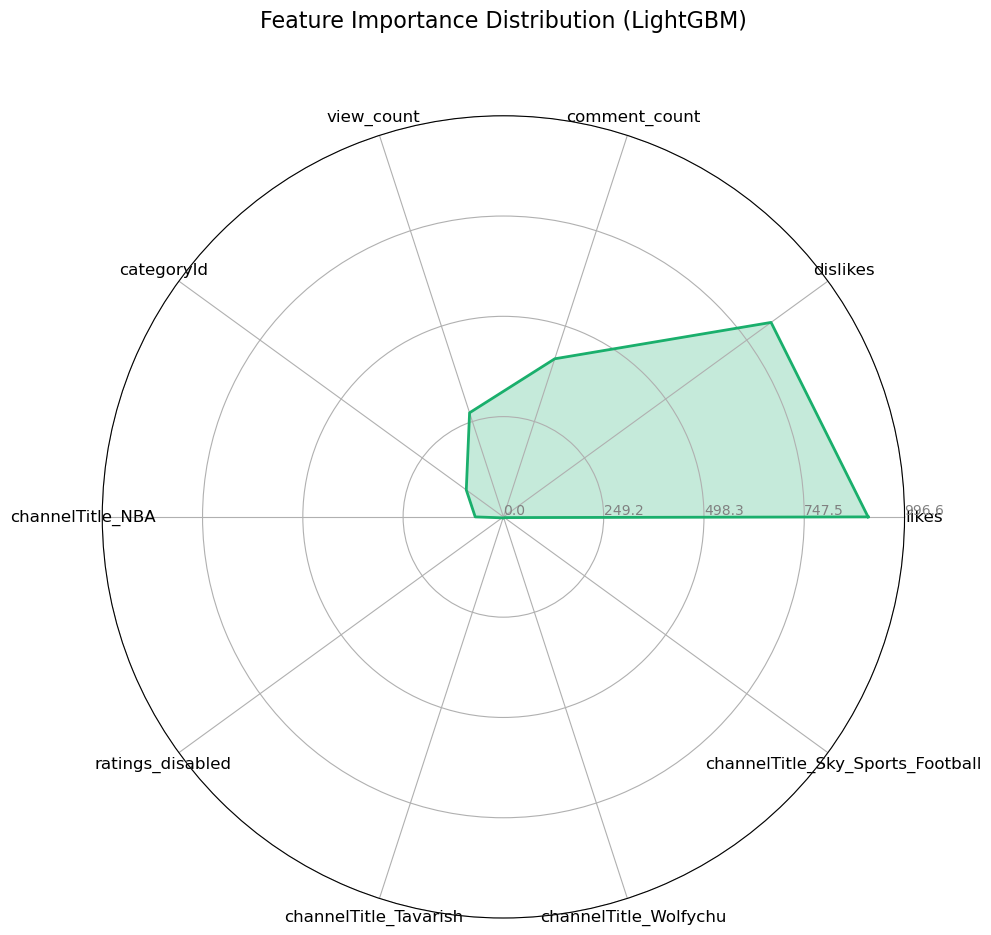

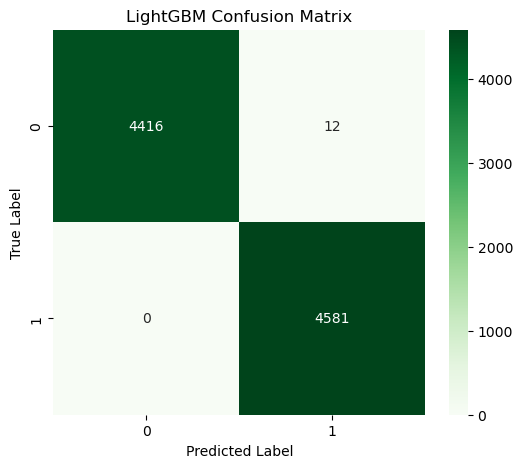

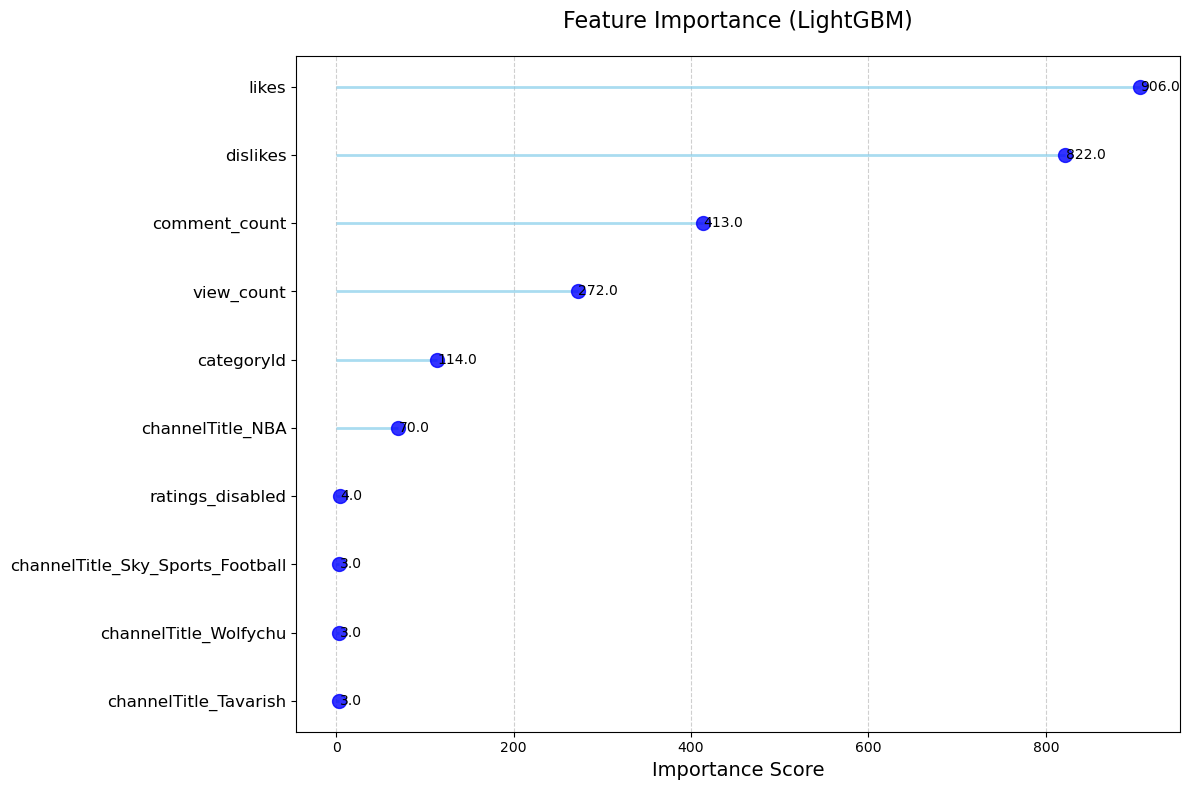

In [26]:
# LIGHTGBM MODEL
print("\n===== LightGBM Model =====")

# Clean column names to avoid special JSON character errors
X_clean = X.copy()
# Create a mapping of original column names to cleaned column names
clean_names = {}
for col in X_clean.columns:
    # Replace special characters with underscores
    clean_col = col.replace('[', '_').replace(']', '_').replace(',', '_').replace(':', '_').replace('"', '_').replace("'", "_").replace(' ', '_')
    clean_names[col] = clean_col

# Rename columns
X_clean = X_clean.rename(columns=clean_names)
X_train_clean = X_train.rename(columns=clean_names)
X_test_clean = X_test.rename(columns=clean_names)

# Create LightGBM dataset format with clean feature names
lgb_train = lgb.Dataset(X_train_clean, y_train)
lgb_eval = lgb.Dataset(X_test_clean, y_test, reference=lgb_train)

# Set parameters
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# Train the model
# Your existing code remains unchanged
# Train the model
# Your existing code remains unchanged
# Train the model
lgb_model = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=[lgb_train, lgb_eval],
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)

# Make predictions
y_pred_lgb_prob = lgb_model.predict(X_test_clean, num_iteration=lgb_model.best_iteration)
y_pred_lgb = (y_pred_lgb_prob > 0.5).astype(int)

# Evaluate the model
print("\n LightGBM Evaluation:")
print(classification_report(y_test, y_pred_lgb))
lgb_accuracy = accuracy_score(y_test, y_pred_lgb)
lgb_precision = precision_score(y_test, y_pred_lgb)
lgb_recall = recall_score(y_test, y_pred_lgb)
lgb_f1 = f1_score(y_test, y_pred_lgb)

# LIGHTGBM FEATURE IMPORTANCE
# ADDITIONAL VISUALIZATION - RADAR CHART FOR FEATURE IMPORTANCE
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

# Function to create radar chart
def radar_chart(categories, values, title):
    # Number of variables
    N = len(categories)
    
    # What will be the angle of each axis in the plot (divide the plot / number of variables)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Initialize the plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    # Draw one axis per variable and add labels
    plt.xticks(angles[:-1], categories, size=12)
    
    # Draw the y-axis labels (importance values)
    ax.set_rlabel_position(0)
    max_val = max(values) * 1.1  # Add some margin
    plt.yticks(np.linspace(0, max_val, 5), 
               [f"{v:.1f}" for v in np.linspace(0, max_val, 5)], 
               color="grey", size=10)
    plt.ylim(0, max_val)
    
    # Plot data
    values += values[:1]  # Close the loop
    ax.plot(angles, values, linewidth=2, linestyle='solid', color='#1aaf6c')
    
    # Fill area
    ax.fill(angles, values, color='#1aaf6c', alpha=0.25)
    
    # Add title
    plt.title(title, size=16, y=1.1)
    
    return fig, ax

# Sort features by importance (optional)
sorted_features = lgb_top_features.sort_values('Importance', ascending=False)

# Create the radar chart
fig, ax = radar_chart(
    sorted_features['Feature'].tolist(),
    sorted_features['Importance'].tolist(),
    'Feature Importance Distribution (LightGBM)'
)

plt.tight_layout()
plt.show()



# LIGHTGBM CONFUSION MATRIX
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred_lgb), annot=True, fmt='d', cmap='Greens')
plt.title('LightGBM Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ADD THE NEW PIE CHART CODE HERE (in a new cell or after the above code)
# ADDITIONAL VISUALIZATION - HORIZONTAL LOLLIPOP CHART FOR FEATURE IMPORTANCE
plt.figure(figsize=(12, 8))
# Sort features by importance for better visualization
sorted_features = lgb_top_features.sort_values('Importance')
# Create the lollipop chart
plt.hlines(y=range(len(sorted_features)), xmin=0, xmax=sorted_features['Importance'], color='skyblue', alpha=0.7, linewidth=2)
plt.plot(sorted_features['Importance'], range(len(sorted_features)), "o", markersize=10, color='blue', alpha=0.8)
# Add feature names and values
plt.yticks(range(len(sorted_features)), sorted_features['Feature'], fontsize=12)
for i, v in enumerate(sorted_features['Importance']):
    plt.text(v + 0.5, i, f"{v:.1f}", va='center', fontsize=10)
# Styling
plt.xlabel('Importance Score', fontsize=14)
plt.title('Feature Importance (LightGBM)', fontsize=16, pad=20)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()






In [12]:
# LINEARSVC MODEL
print("\n===== LinearSVC Model =====")

# Configure LinearSVC with optimized parameters to prevent memory issues
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# Create a LinearSVC model with memory-optimized parameters
# - dual=False is faster when n_samples > n_features
# - max_iter increased to allow convergence
# - tol parameter controls precision of the solution
linear_svc = LinearSVC(
    random_state=42,
    dual=False,  # Faster for n_samples > n_features
    C=1.0,       # Regularization parameter
    max_iter=10000,  # Increased to ensure convergence
    tol=1e-4     # Tolerance for stopping criteria
)

# Wrap with CalibratedClassifierCV to get probability estimates
# (LinearSVC doesn't provide probability estimates by default)
svm_model = CalibratedClassifierCV(linear_svc, cv=3)

# Fit the model
print("Training LinearSVC model...")
svm_model.fit(X_train, y_train)
print("Training complete!")

# Make predictions
y_pred_svm = svm_model.predict(X_test)
y_pred_svm_prob = svm_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("\n LinearSVC Evaluation:")
print(classification_report(y_test, y_pred_svm))
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_precision = precision_score(y_test, y_pred_svm)
svm_recall = recall_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm)

# SVM FEATURE IMPORTANCE (COEFFICIENTS)
plt.figure(figsize=(10, 6))
# Get coefficients from the underlying LinearSVC model
svm_importances = np.abs(linear_svc.coef_[0])
svm_top_features = pd.DataFrame({'Feature': X.columns, 'Importance': svm_importances}).sort_values(by='Importance', ascending=False).head(10)
sns.barplot(x='Importance', y='Feature', data=svm_top_features, palette='magma')
plt.title('Top 10 Feature Importances (LinearSVC)')
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# SVM CONFUSION MATRIX
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Purples')
plt.title('LinearSVC Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()




===== LinearSVC Model =====
Training LinearSVC model...
Training complete!

 LinearSVC Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4428
           1       0.99      0.99      0.99      4581

    accuracy                           0.99      9009
   macro avg       0.99      0.99      0.99      9009
weighted avg       0.99      0.99      0.99      9009



AttributeError: 'LinearSVC' object has no attribute 'coef_'

<Figure size 1000x600 with 0 Axes>

In [13]:
# MODEL COMPARISON
comparison = pd.DataFrame({
    'Model': ['LightGBM', 'LinearSVC'],
    'Accuracy': [lgb_accuracy, svm_accuracy],
    'Precision': [lgb_precision, svm_precision],
    'Recall': [lgb_recall, svm_recall],
    'F1 Score': [lgb_f1, svm_f1]
})
print("\n Model Performance Comparison:")
print(comparison)

# DETERMINE BEST MODEL
best_f1 = max(lgb_f1, svm_f1)
if best_f1 == lgb_f1:
    best_model = 'LightGBM'
    model_to_save = lgb_model
else:
    best_model = 'LinearSVC'
    model_to_save = svm_model

print(f"\n Best Model Based on F1 Score: *{best_model}*")




 Model Performance Comparison:
       Model  Accuracy  Precision    Recall  F1 Score
0   LightGBM  0.998668   0.997387  1.000000  0.998692
1  LinearSVC  0.989122   0.991019  0.987557  0.989285

 Best Model Based on F1 Score: *LightGBM*


In [14]:
# SAVE & UPLOAD BEST MODEL
model_filename = f"{best_model.lower().replace(' ', '_').replace('(', '').replace(')', '')}_model.pkl"
joblib.dump(model_to_save, model_filename)
s3.upload_file(model_filename, bucket, f'models/{model_filename}')
print(f" Model uploaded to s3://{bucket}/models/{model_filename}")

 Model uploaded to s3://youtube-trending-cleaned/models/lightgbm_model.pkl
